# **0. Imports**

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

ModuleNotFoundError: No module named 'statsmodels'

## **0.1 Load Dataset**

In [69]:
data = pd.read_csv('../data/data_trab2_econometria.csv')
crb = pd.read_csv('../data/^cry_m.csv')
data.head()

,Data,inflacao,cambio,juros
0,2003,"1,98","3,44","26,38"
1,2003,"2,19","3,59","24,31"
2,2003,"1,14","3,45","23,58"
3,2003,"1,14","3,12","24,90"
4,2003,"0,85","2,95","26,38"


# **1.0 Data Description**

In [22]:
df1 = data.copy()

## **1.1 Rename columns**

In [23]:
cols_new = ['date','cpi', 'exchange_rate','interest_rate']
df1.columns = cols_new

## **1.2 Data Dimensions**

In [24]:
print('Number of rows:', format(df1.shape[0]))
print('Number of columns:', format(df1.shape[1]))

Number of rows: 223
Number of columns: 4


## **1.3 Data types**

In [25]:
df1.dtypes

date              int64
cpi              object
exchange_rate    object
interest_rate    object
dtype: object

## **1.4 Check NA**

In [26]:
df1.isna().sum()

date             0
cpi              0
exchange_rate    0
interest_rate    0
dtype: int64

## **1.5 Change Types**

In [27]:
df1['date'] = pd.to_datetime(df1['date'].astype(str))
#change comma to point decimal

cols = ['cpi', 'exchange_rate', 'interest_rate']

for col in cols:
    df1[col] = df1[col].apply(lambda x: x.replace(',', '.'))



In [28]:
df1['cpi'] = df1['cpi'].astype('float64')
df1['exchange_rate'] = df1['exchange_rate'].astype('float64')
df1['interest_rate'] = df1['interest_rate'].astype('float64')


## **1.6 Descriptive Statistical**

In [29]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
num_attributes

,cpi,exchange_rate,interest_rate
0,1.98,3.44,26.38
1,2.19,3.59,24.31
2,1.14,3.45,23.58
3,1.14,3.12,24.90
4,0.85,2.95,26.38
...,...,...,...
218,0.93,5.65,2.43
219,0.60,5.56,2.55
220,0.44,5.29,3.29
221,0.83,5.03,3.78


### **1.5.1 Numerical Attributes**

In [30]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
m = pd.concat([d1, d2, d3, d4, ct1, ct2, d5, d6]).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m
m.columns = ['Attributes', 'Std', 'min', 'max', 'Range', 'mean', 'median', 'Skew', 'Kurtosis']
m

,Attributes,Std,min,max,Range,mean,median,Skew,Kurtosis
0,cpi,0.340103,-0.59,2.19,2.78,0.473004,0.44,1.081433,3.933787
1,exchange_rate,1.031950,1.56,5.65,4.09,2.807892,2.41,1.035665,0.447822
2,interest_rate,5.123448,1.57,28.02,26.45,11.362825,10.95,0.570216,0.615377


# **2.0 Modelling**

In [65]:
df2 = df1.copy()
df2.dtypes

date             datetime64[ns]
cpi                     float64
exchange_rate           float64
interest_rate           float64
dtype: object

## **2.1 Plotting series**

In [77]:
crb = crb['Close']
df2['crb_index'] = crb 

0    210.61
1    221.97
2    204.24
3    199.95
4    208.64
Name: Close, dtype: float64

Text(0.5, 1.0, 'CRB Index: 2003 - 2021')

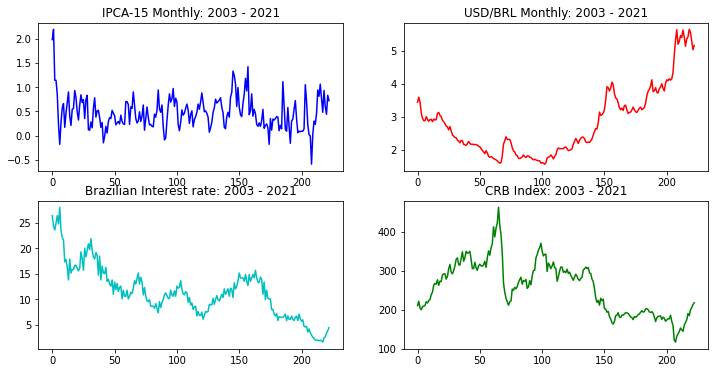

In [82]:
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(df2['cpi'], color = 'b')
plt.title('IPCA-15 Monthly: 2003 - 2021')

plt.subplot(2, 2, 2)
plt.plot(df2['exchange_rate'], color = 'r')
plt.title('USD/BRL Monthly: 2003 - 2021')

plt.subplot(2, 2, 3)
plt.plot(df2['interest_rate'], color = 'c')
plt.title('Brazilian Interest rate: 2003 - 2021')

plt.subplot(2, 2, 4)
plt.plot(df2['crb_index'], color = 'g')
plt.title('CRB Index: 2003 - 2021')


## **2.2 Check if series are stacionary**

### **2.2.1 ADF Test (CPI)**

ModuleNotFoundError: No module named 'statsmodels'